# Data Analysis of Pitchfork Review SQL dataset

Pitchfork.com is a website where users publically upload reviews of albums. The data of over 20,000 reviews is analysed in this notebook. Firstly some exploratory data analysis is needed to understand the data before posing questions. We start by opening a connection to the SQLite database stored locally within the python environment:

In [64]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

engine = create_engine('sqlite:///pitchfork.sqlite')
con = engine.connect()
#insert query string to initialise the ResultProxy
proxy = con.execute('SELECT score,genre,pub_year\
                    FROM reviews\
                    INNER JOIN genres USING(reviewid)')
#convert to a pandas dataframe for more intricate manipulation
gen_rev = pd.DataFrame(proxy.fetchall())
gen_rev.columns = proxy.keys()
con.close()

gen_rev.head()

,score,genre,pub_year
0,9.3,electronic,2017
1,7.9,metal,2017
2,7.3,rock,2017
3,9.0,rock,2017
4,8.1,electronic,2017


#The purpose of this connection is to load the relevant columns from the SQL relational database into a pandas DataFrame for more intricate analysis. The matplotlib.pyplot and seaborn modules are also imported in order to later visualise data.

## 1) Correlations between review score and genre.

First we can investigate if different genres have an impact on the mean score recieved. We can start by taking a global average of all genres and comparing to the mean within genre, which turns out to be about 7. 

In [65]:
mean_score = gen_rev['score'].mean()
print(mean_score)

6.991154693697664


Now we can group by genre and see how that affects the results. Since we are analysing aggregate functions of discrete groups of data, the best visualisation of this data would be box plots. This way we can compare to our overall mean score. We will omitt missing genre data values so they do not skew the rest of the data.

In [67]:
gen_rev.dropna()
gen = gen_rev.groupby('genre').mean()
print(gen)

                 score     pub_year
genre                              
electronic    6.920702  2008.430821
experimental  7.336694  2008.206061
folk/country  7.202190  2008.483212
global        7.429680  2008.899543
jazz          7.303908  2006.977011
metal         6.950000  2008.595128
pop/r&b       6.883799  2009.456704
rap           6.900513  2010.086594
rock          6.942011  2007.957618


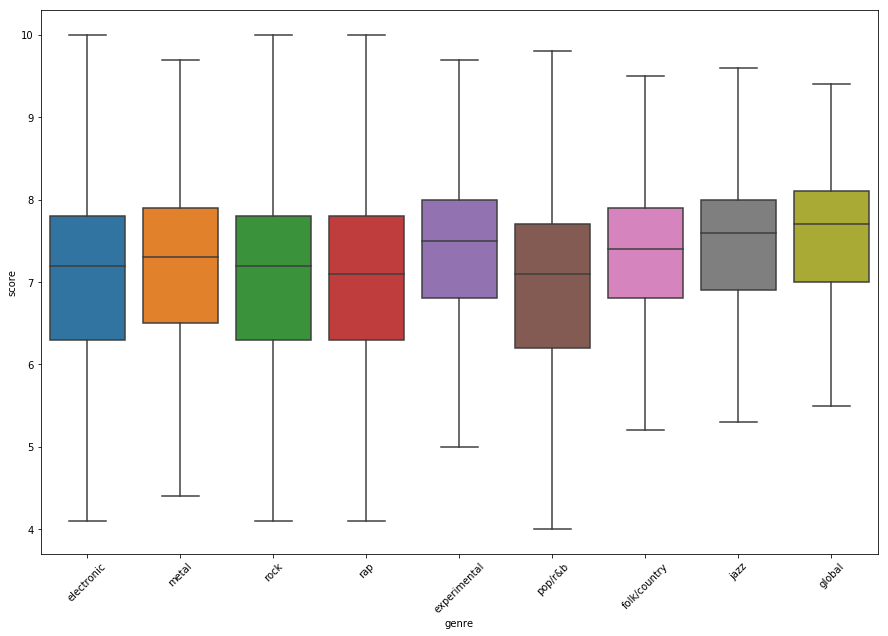

In [68]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
box = sns.boxplot(x='genre',y='score',data=gen_rev,showfliers=False)
box.set_xticklabels(box.get_xticklabels(),rotation = 45)
plt.show()

 Generally, all genres have similar means to the global mean of score 7. Experimental, Jazz and Global/World music seem to have slightly higher average scores. One of the standout features is that electronic, rock, rap, and pop have quite wide plots, indicating that the variance in these genres is quite high, where as all the rest are quite low. The wide swing in genre score for these genres could be correlated with the amount of reviews for these genres.

In [110]:
counts = gen_rev[['score','genre']].groupby('genre').count()
counts.columns = ['Count']
counts

,Count
genre,
electronic,3874
experimental,1815
folk/country,685
global,219
jazz,435
metal,862
pop/r&b,1432
rap,1559
rock,9438


Seems there could be a connection between number of reviews and the size of the box plot (max-min excluding outliers). To do this we must write a function to return maximum and minimum values.

In [116]:
def maxmin(x):
    """Takes a pandas dataseries as argument and returns the width of the box plot whiskers"""
    Q1, Q3 = np.percentile(x,[25,75])
    IQR = Q3 - Q1
    uppb = Q3 + 1.5*IQR
    lowb = Q1 - 1.5*IQR
    diff = uppb - lowb
    return diff

Now we can apply it to our scores for each genre and see if there is a correlation.

In [117]:
size = gen_rev[['genre','score']].groupby('genre').apply(maxmin)
size

genre
electronic      6.0
experimental    4.8
folk/country    4.4
global          4.4
jazz            4.4
metal           5.6
pop/r&b         6.0
rap             6.0
rock            6.0
dtype: float64

Let's make a scatter plot of the data range against data size for each genre. 

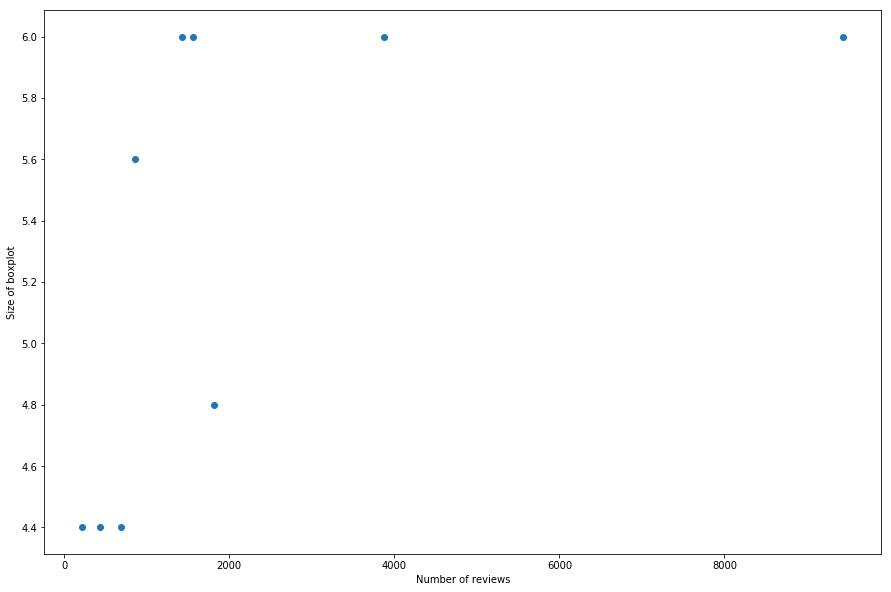

In [151]:
plt.scatter(list(np.float_(counts.Count)),list(np.array(size)))
plt.xlabel('Number of reviews')
plt.ylabel('Size of boxplot')

plt.show()

From this we can conclude that there is a general trend that the more populated genres have larger data ranges, which is to be expected, but we do not have enough genres to work with to make a general comment about their correlation!

## 2) How does review year affect review score?

The dataset runs from 1999 to 2017. Could it be that the reviews have become more or less critical on average?

In [89]:
gen_rev.index = gen_rev.pub_year
gen_rev.index = pd.to_datetime(gen_rev.index,format='%Y')
resampled = pd.DataFrame()
resampled['score'] = gen_rev.score.resample('A').mean()
resampled

,score
pub_year,
1999-12-31,6.806485
2000-12-31,6.815743
2001-12-31,7.130265
2002-12-31,6.841544
2003-12-31,6.936377
2004-12-31,7.196025
2005-12-31,7.038633
2006-12-31,6.978964
2007-12-31,6.871085


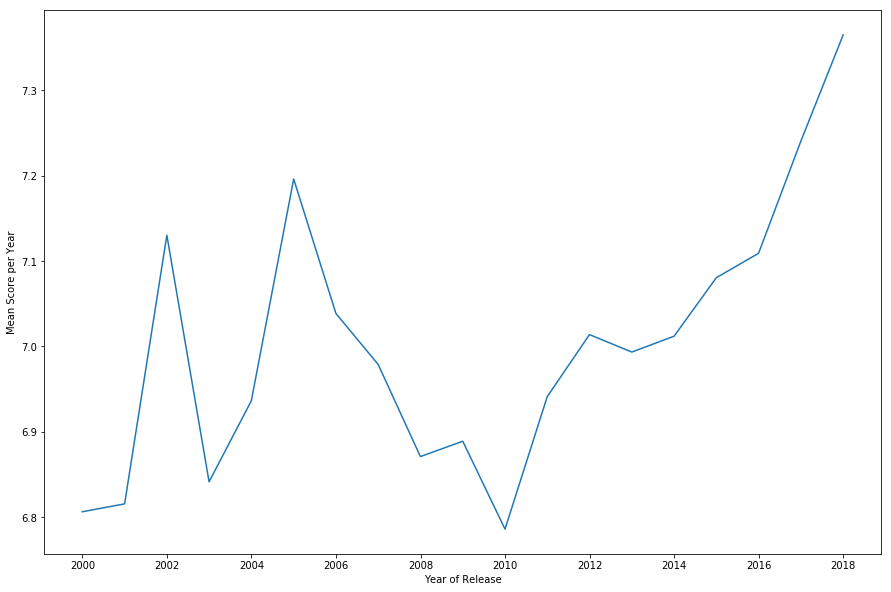

In [146]:
plt.plot(resampled.index,resampled['score'])
plt.xlabel('Year of Release')
plt.ylabel('Mean Score per Year')
plt.show()

Quite an interesting result! There seems to be a larger variation in the earlier reviews in about the 7 range. Close to 2005 to 2010 the review authors, seem to have been getting more critical. After 2010 the scores generally inclined.